Time Series 
Gold Price in USD 

In [36]:
!pip install -q kaggle

In [93]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bayusulistiyawan","key":"ac683652beff2450b83ea3404d402ca1"}'}

In [94]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [105]:
!kaggle datasets download -d sonukiller99/gold-price-from-1978-till-2020-in-24-currencies

  0% 0.00/2.03M [00:00<?, ?B/s]
100% 2.03M/2.03M [00:00<00:00, 67.7MB/s]


In [114]:
!mkdir goldprice
!unzip gold-price-from-1978-till-2020-in-24-currencies.zip -d goldprice
!ls goldprice

Archive:  gold-price-from-1978-till-2020-in-24-currencies.zip
  inflating: goldprice/Gold_Prices.xlsx  
Gold_Prices.xlsx


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM

In [116]:
#load datashet
df=pd.read_excel('goldprice/Gold_Prices.xlsx')
df.head()

,Name,US dollar,Euro,Japanese yen,Pound sterling,Canadian dollar,Swiss franc,Indian rupee,Chinese renmimbi,US dollar.1,Turkish lira,Saudi riyal,Indonesian rupiah,UAE dirham,Thai baht,Vietnamese dong,Egyptian pound,Korean won,Euro.1,Russian ruble,US dollar.2,South African rand,Chinese renmimbi.1,Canadian dollar.1,Australian dollar
0,1978-12-29,226.00,137.06,NaN,110.70,NaN,NaN,NaN,NaN,226.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.06,NaN,226.00,NaN,NaN,NaN,NaN
1,1979-01-01,226.00,137.06,NaN,110.70,NaN,NaN,NaN,NaN,226.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.06,NaN,226.00,NaN,NaN,NaN,NaN
2,1979-01-02,226.80,137.29,43164.91,111.45,263.74,359.62,1792.85,NaN,226.80,NaN,735.60,138160.45,851.29,4454.55,NaN,NaN,107470.04,137.29,NaN,226.80,194.56,NaN,263.74,193.61
3,1979-01-03,218.60,134.01,43717.90,107.98,264.39,365.87,1802.15,NaN,218.60,NaN,739.42,138877.01,855.71,4477.66,NaN,NaN,108027.43,134.01,NaN,218.60,192.23,NaN,264.39,192.97
4,1979-01-04,223.15,136.79,43674.89,110.66,264.14,366.38,1811.74,NaN,223.15,NaN,743.36,139616.26,860.26,4501.49,NaN,NaN,108602.47,136.79,NaN,223.15,193.01,NaN,264.14,194.55


In [117]:
df.shape

(10901, 25)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                10901 non-null  datetime64[ns]
 1   US dollar           10901 non-null  float64       
 2   Euro                10901 non-null  float64       
 3   Japanese yen        10899 non-null  float64       
 4   Pound sterling      10901 non-null  float64       
 5   Canadian dollar     10899 non-null  float64       
 6   Swiss franc         10899 non-null  float64       
 7   Indian rupee        10899 non-null  float64       
 8   Chinese renmimbi    9330 non-null   float64       
 9   US dollar.1         10901 non-null  float64       
 10  Turkish lira        9856 non-null   float64       
 11  Saudi riyal         10899 non-null  float64       
 12  Indonesian rupiah   10899 non-null  float64       
 13  UAE dirham          10899 non-null  float64   

In [119]:
df.isnull().sum()

Name                     0
US dollar                0
Euro                     0
Japanese yen             2
Pound sterling           0
Canadian dollar          2
Swiss franc              2
Indian rupee             2
Chinese renmimbi      1571
US dollar.1              0
Turkish lira          1045
Saudi riyal              2
Indonesian rupiah        2
UAE dirham               2
Thai baht                2
Vietnamese dong       2851
Egyptian pound        2591
Korean won               2
Euro.1                   0
Russian ruble         3661
US dollar.2              0
South African rand       2
Chinese renmimbi.1    1571
Canadian dollar.1        2
Australian dollar        2
dtype: int64

In [120]:
dollar=df[['Name','US dollar']].copy()
dollar = dollar.rename(columns={'US dollar': 'Price'})
dollar['Date'] = dollar['Name'].dt.date

dollarfinal=dollar.drop('Name',axis=1)
dollarfinal.set_index('Date', inplace= True)
dollarfinal.head()

,Price
Date,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15


In [121]:
dollarfinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10901 entries, 1978-12-29 to 2020-10-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   10901 non-null  float64
dtypes: float64(1)
memory usage: 170.3+ KB


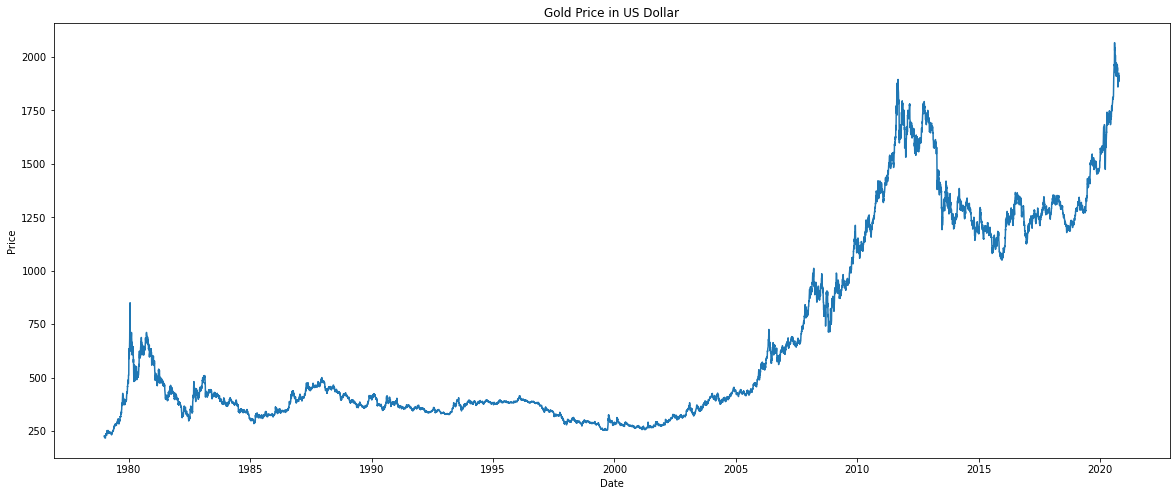

In [122]:
plt.figure(figsize=(20,8))
plt.plot(dollarfinal)
plt.title('Gold Price in US Dollar')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [124]:
# get data values
date = df['Name'].values
price = df['US dollar'].values

In [125]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [126]:
x_train, x_test, y_train, y_test = train_test_split(price, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

8720 2181


In [128]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [129]:
max = df['US dollar'].max()
print('Max value : ' )
print(max)
min = df['US dollar'].min()
print('Min Value : ')
print(min)

x = (max - min) * (10 / 100)
print(x)

Max value : 
2067.15
Min Value : 
216.85
185.03000000000003


In [130]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [131]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
87/87 [==============================] - 17s 151ms/step - loss: 474.0941 - mae: 474.5941 - val_loss: 1319.1362 - val_mae: 1319.6363
Epoch 2/500
87/87 [==============================] - 13s 139ms/step - loss: 470.7081 - mae: 471.2081 - val_loss: 1315.5542 - val_mae: 1316.0543
Epoch 3/500
87/87 [==============================] - 13s 140ms/step - loss: 467.6477 - mae: 468.1477 - val_loss: 1312.3882 - val_mae: 1312.8882
Epoch 4/500
87/87 [==============================] - 13s 140ms/step - loss: 464.7852 - mae: 465.2851 - val_loss: 1309.5581 - val_mae: 1310.0582
Epoch 5/500
87/87 [==============================] - 13s 140ms/step - loss: 462.0047 - mae: 462.5046 - val_loss: 1306.8688 - val_mae: 1307.3687
Epoch 6/500
87/87 [==============================] - 13s 139ms/step - loss: 459.2062 - mae: 459.7062 - val_loss: 1304.1794 - val_mae: 1304.6794
Epoch 7/500
87/87 [==============================] - 13s 138ms/step - loss: 456.2938 - mae: 456.7938 - val_loss: 1301.4022 - val_mae: 13

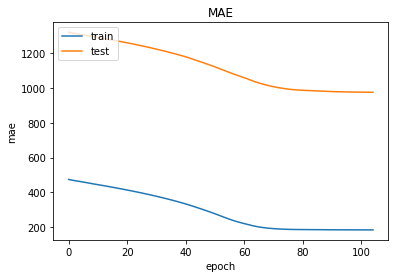

In [132]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

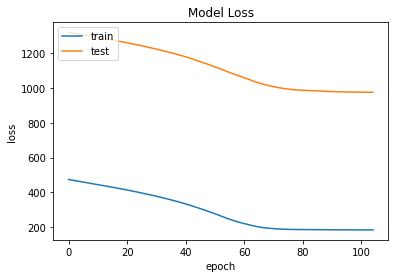

In [133]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()